<a href="https://colab.research.google.com/github/aeedgewoasu/ASU-BSD-Capstone-2023/blob/main/Mineral_Image_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Training with YOLOv5

In this tutorial, we assemble a dataset and train a custom YOLOv5 model to recognize the objects in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work



![](https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/615627e5824c9c6195abfda9_computer-vision-cycle.png)

# Step 1: Install Requirements

In [ ]:
#clone YOLOv5 and
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 15994, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15994 (delta 18), reused 18 (delta 12), pack-reused 15967
Receiving objects: 100% (15994/15994), 14.65 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (10984/10984), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.8 MB/s eta

# Step 2: Assemble Our Dataset

In order to train our custom model, we need to assemble a dataset of representative images with bounding box annotations around the objects that we want to detect. And we need our dataset to be in YOLOv5 format.

In Roboflow, you can choose between two paths:

* Convert an existing dataset to YOLOv5 format. Roboflow supports over [30 formats object detection formats](https://roboflow.com/formats) for conversion.
* Upload raw images and annotate them in Roboflow with [Roboflow Annotate](https://docs.roboflow.com/annotate).

# Annotate

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/roboflow-annotate.gif)

# Version

![](https://roboflow-darknet.s3.us-east-2.amazonaws.com/robolfow-preprocessing.png)


In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gGC5auVEynAuGMhrhoXr")

#first dataset
project1 = rf.workspace("comp-lulu").project("ore-coco")
dataset1 = project1.version(1).download("yolov5")

#second dataset
project2 = rf.workspace("comp-lulu").project("novo-mask")
dataset2 = project2.version(6).download("yolov5")

#third dataset
project3 = rf.workspace("aleksandr-2oaxq").project("test_it")
dataset3 = project3.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets/Ore-COCO-1 in yolov5pytorch:: 100%|██████████| 2453/2453 [00:00<00:00, 4056.94it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets/Novo-Mask-6 in yolov5pytorch:: 100%|██████████| 3244/3244 [00:00<00:00, 4004.39it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets/test_it-2 in yolov5pytorch:: 100%|██████████| 2331/2331 [00:00<00:00, 4059.28it/s]


combine images



In [ ]:
merged_dir = "/content/datasets/new_dataset"
os.makedirs(merged_dir, exist_ok=True)
os.makedirs(merged_dir + "/train/images", exist_ok=True)
os.makedirs(merged_dir + "/train/labels", exist_ok=True)
os.makedirs(merged_dir + "/valid/images", exist_ok=True)
os.makedirs(merged_dir + "/valid/labels", exist_ok=True)

In [ ]:
import os
import shutil

# Merge images and labels from training and validation splits
for dataset_path in [dataset1.location, dataset2.location, dataset3.location]:
    for split in ["train", "valid"]:
        images_src_dir = os.path.join(dataset_path, split, "images")
        labels_src_dir = os.path.join(dataset_path, split, "labels")

        # Copy images
        for image_filename in os.listdir(images_src_dir):
            if image_filename.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(images_src_dir, image_filename)
                shutil.copy(image_path, os.path.join(merged_dir + "/" + split + "/images", image_filename))

        # Copy annotation files (assuming they are in YOLO format)
        for annotation_filename in os.listdir(labels_src_dir):
            annotation_path = os.path.join(labels_src_dir, annotation_filename)
            if os.path.isfile(annotation_path):
                shutil.copy(annotation_path, os.path.join(merged_dir + "/" + split + "/labels", annotation_filename))

# Now, you can use the merged_images_dir and merged_labels_dir for training YOLOv5.

# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training

In [ ]:
!python train.py --img 416 --batch 20 --epochs 150 --data {'/content/datasets/new_dataset'}/data.yaml --weights yolov5s.pt --cache

WARNING ⚠️ invalid check_version(3.1.37, ) requested, please check values.
train: weights=yolov5s.pt, cfg=, data=/content/datasets/new_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=20, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_ep

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {'/content/datasets/Novo-Mask-6'}/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/Novo-Mask-6/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
image 1/20 /content/datasets/Novo-Mask-6/test/images/3linha1_b0t195c0x0-2584y0-1936_png.rf.c98d078770fe2f13ec41a5710981e1b8.jpg: 416x416 2 biotitas, 7.4ms
image 2/20 /content/datasets/Novo-Mask-6/test/images/3linha1_b0t30c0x0-2584y0-19

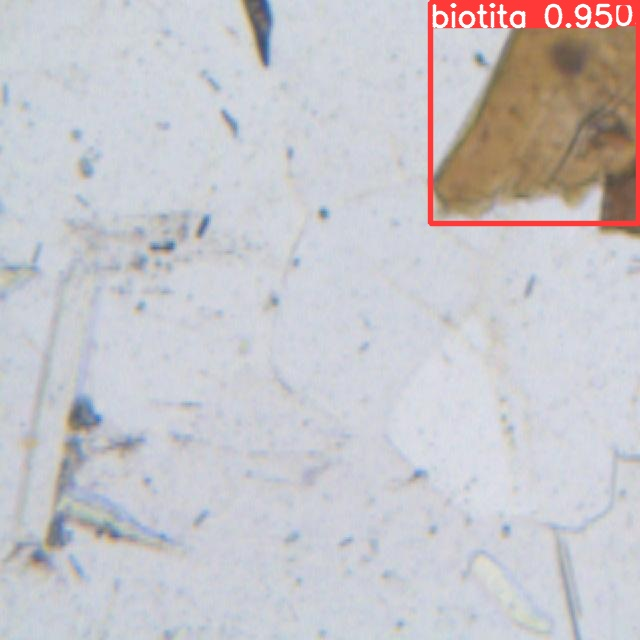

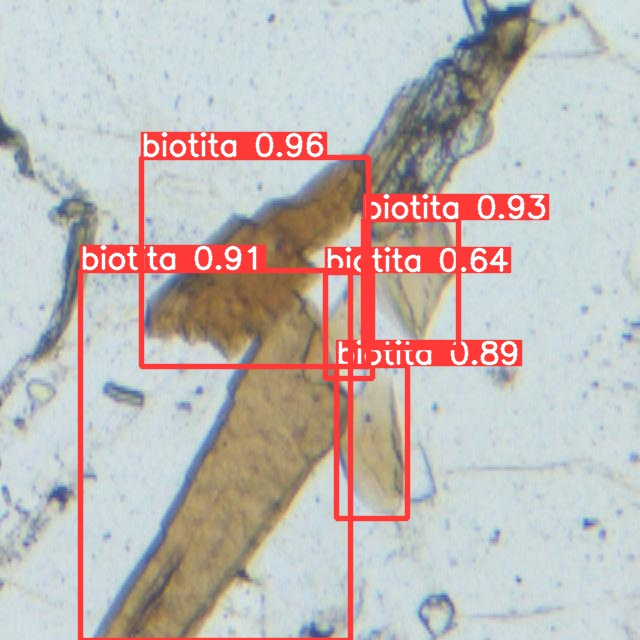

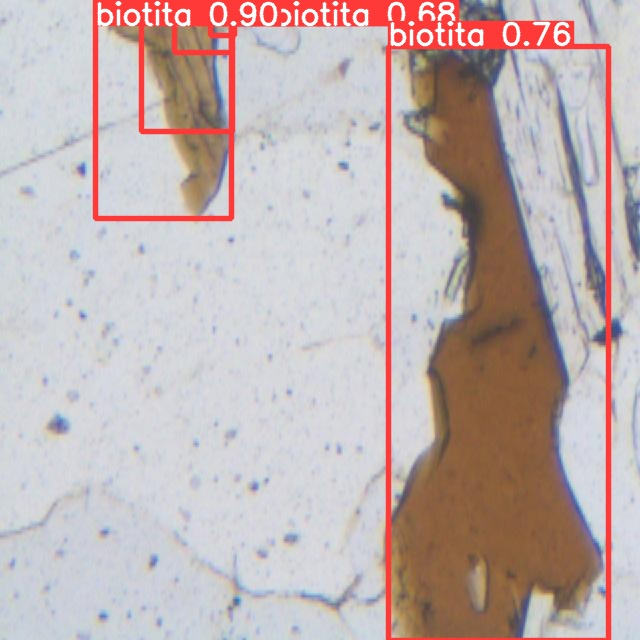

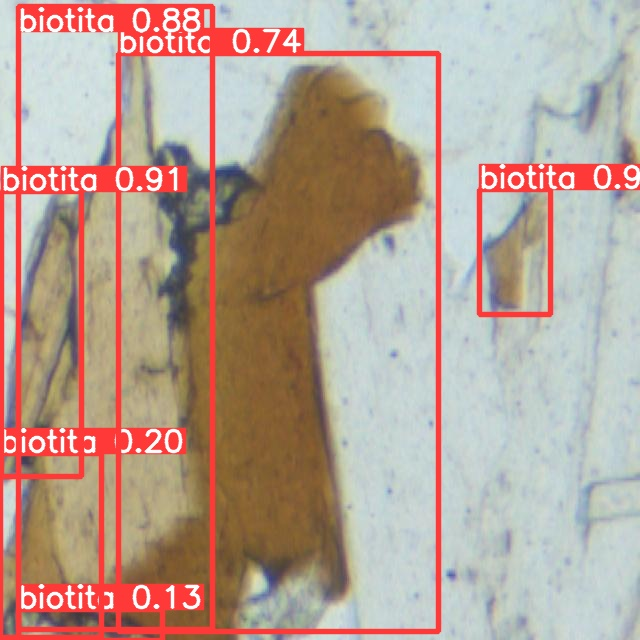

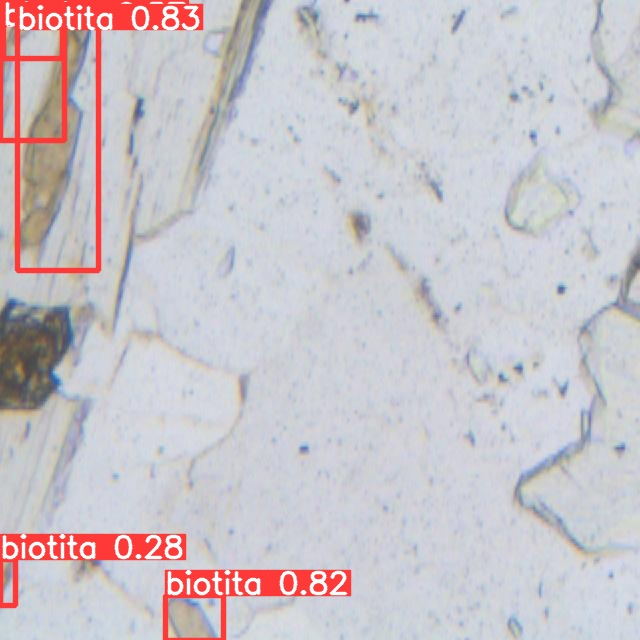

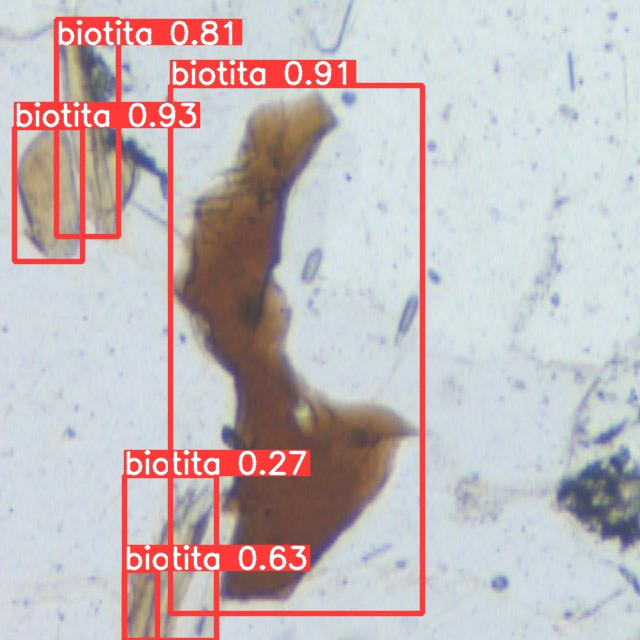

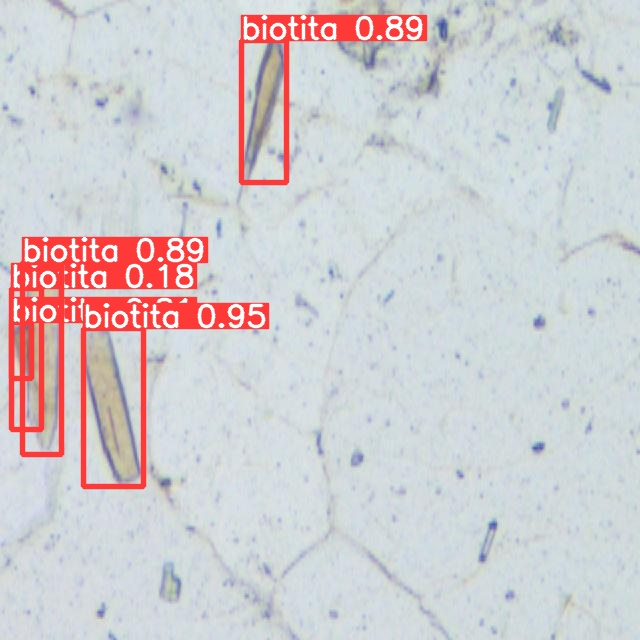

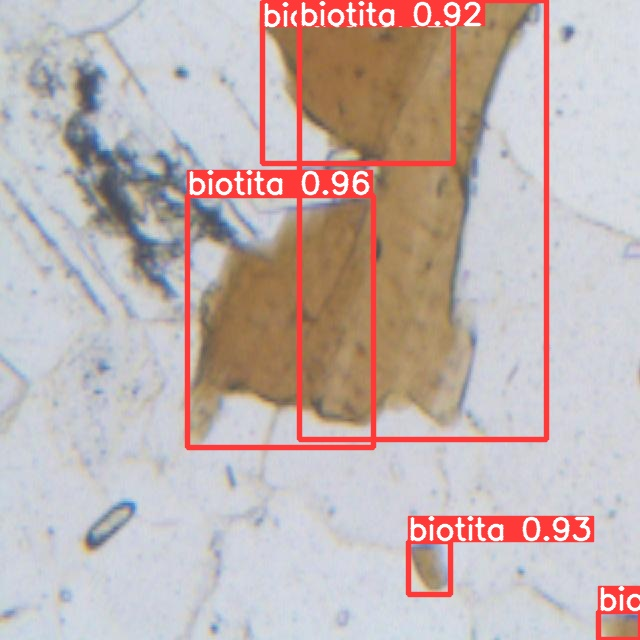

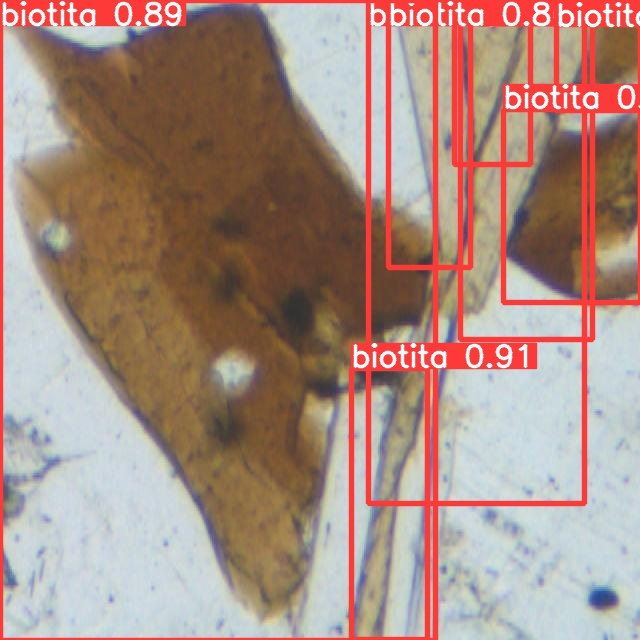

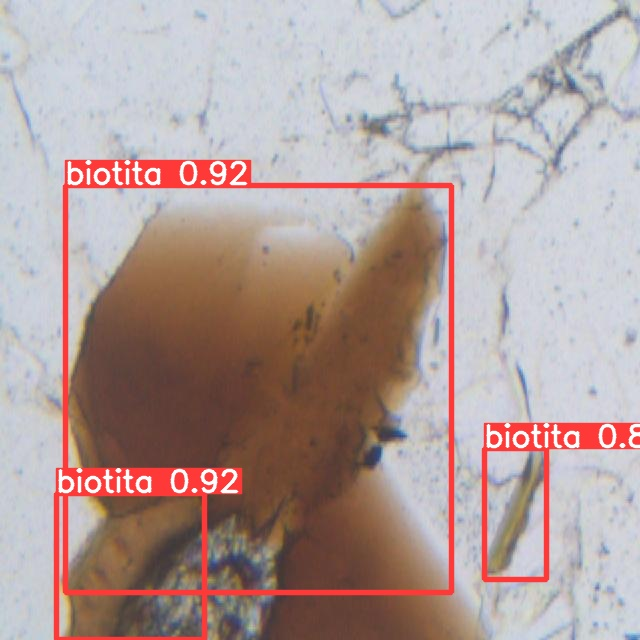

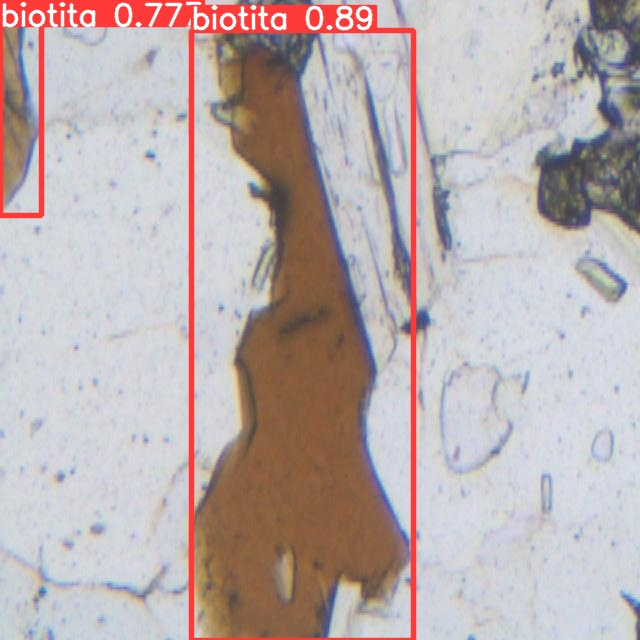

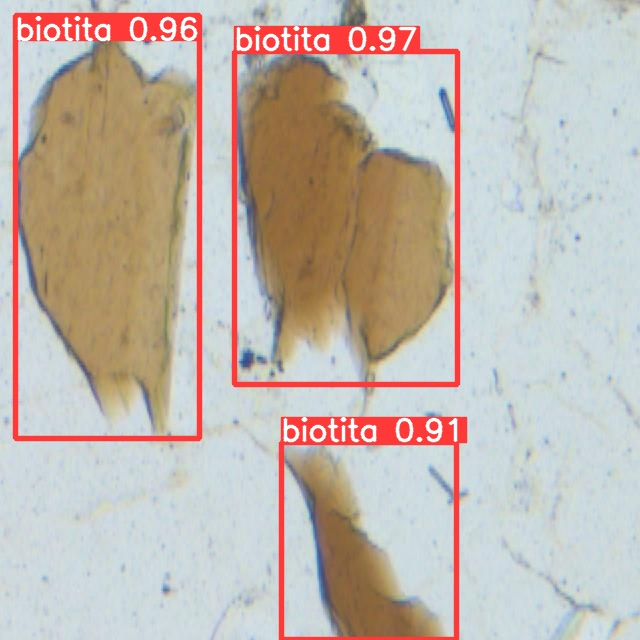

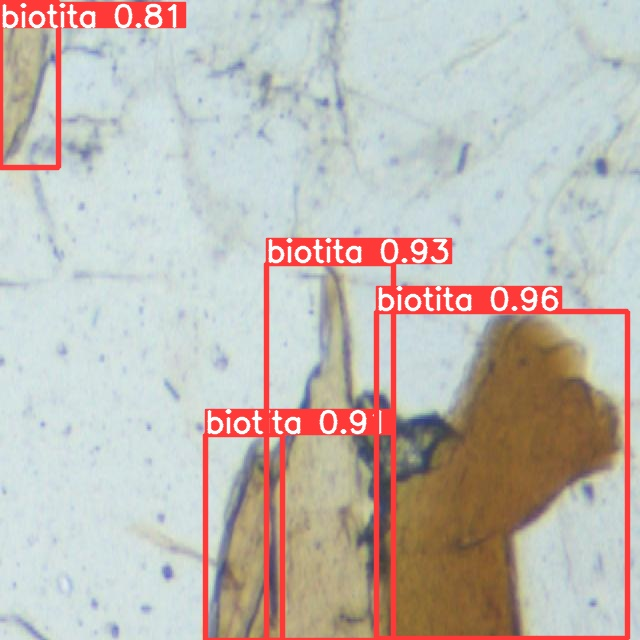

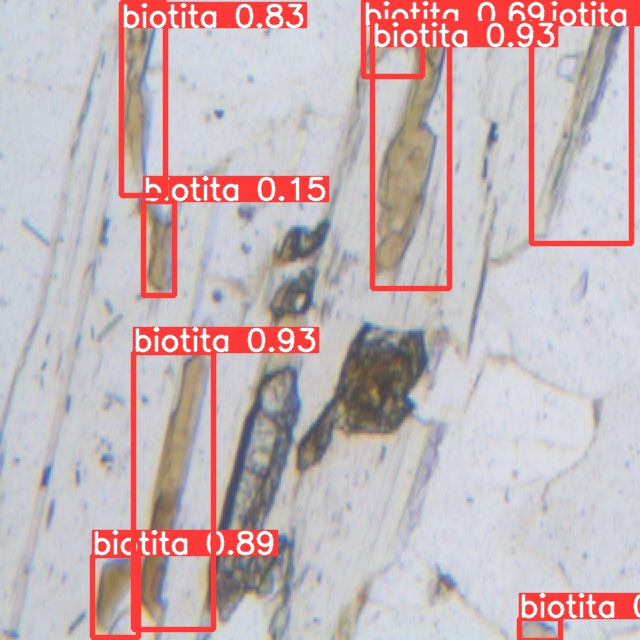

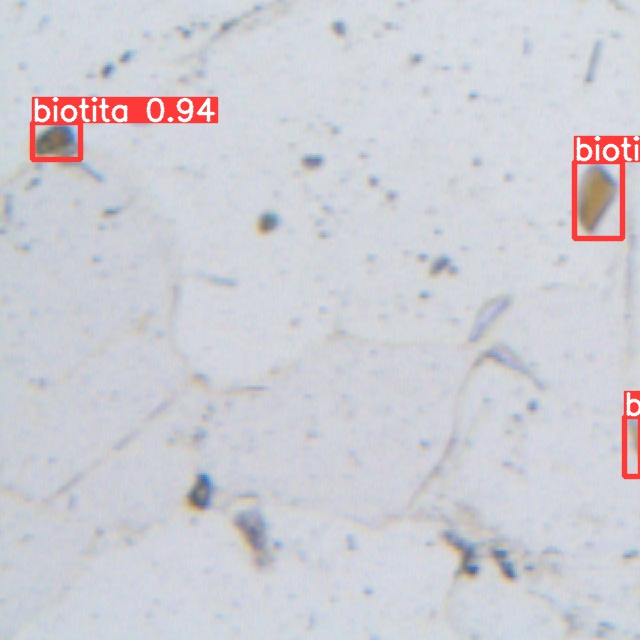

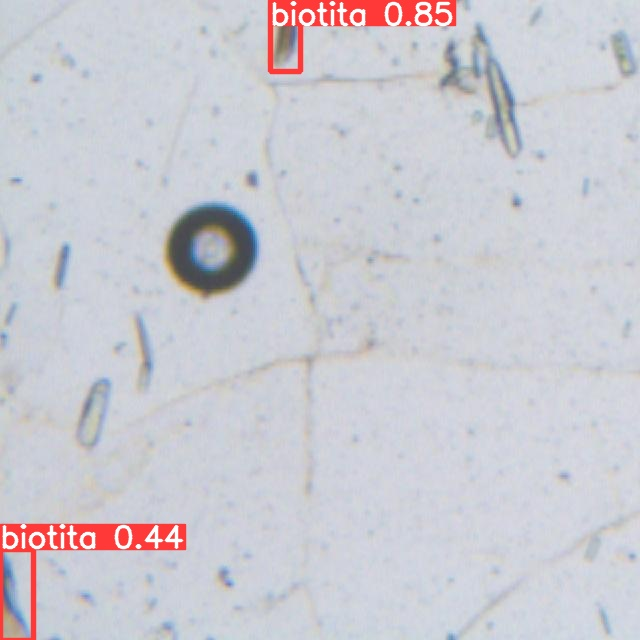

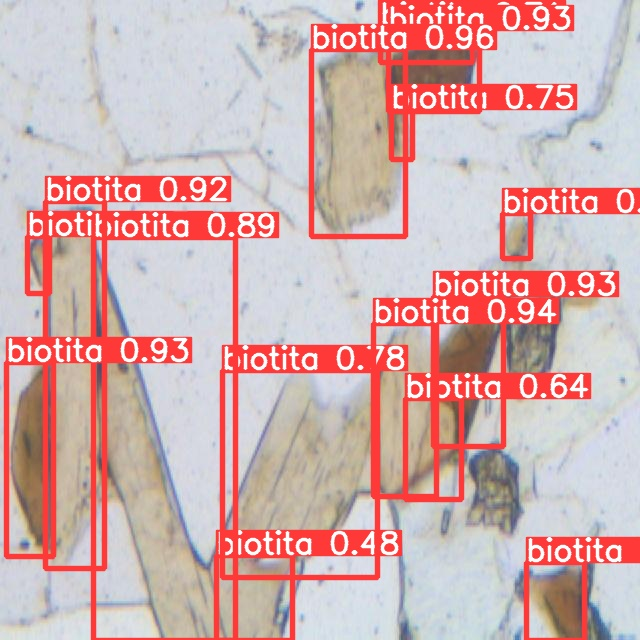

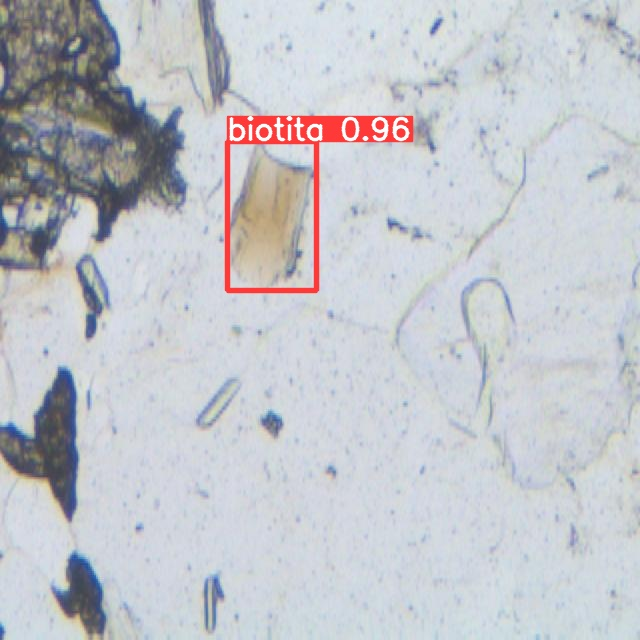

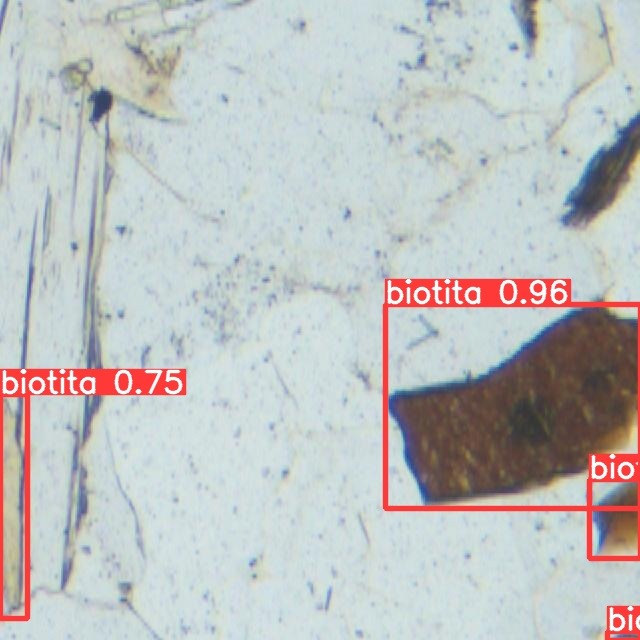

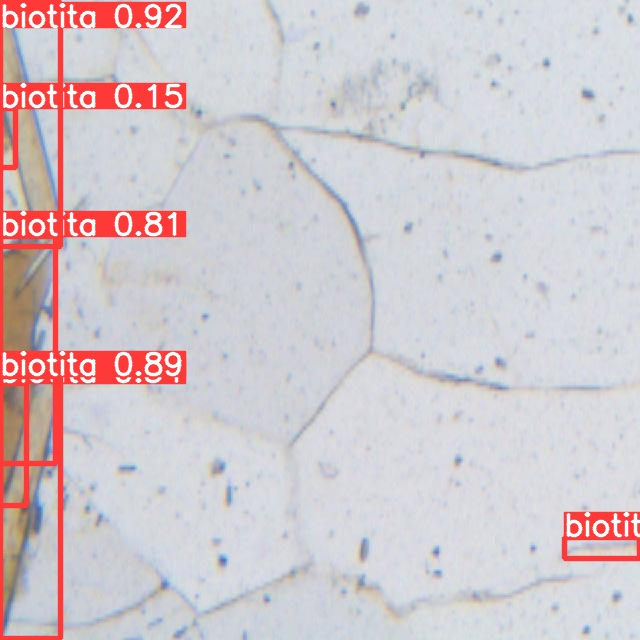

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps

Congratulations! You've trained a custom YOLOv5 model to recognize your custom objects.

To improve you model's performance, we recommend first interating on your datasets coverage and quality. See this guide for [model performance improvement](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results).

To deploy your model to an application, see this guide on [exporting your model to deployment destinations](https://github.com/ultralytics/yolov5/issues/251).

Once your model is in production, you will want to continually iterate and improve on your dataset and model via [active learning](https://blog.roboflow.com/what-is-active-learning/).

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>